# Correlation Metric, Training

In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

import copy

#from tqdm import tqdm, trange

from tqdm.notebook import tqdm as tqdm_n

import os
import wandb
from torchviz import make_dot


In [2]:
from models.community import *
from data.datasets_and_tasks import *
from data.randman import *
from metrics.correlation import fixed_information_data, get_pearson_metrics, fixed_rotation_data
from data.wandb_utils import *

In [3]:
wandb.run is None

True

In [4]:
import warnings
#warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.__version__


'1.10.2'

# MNIST

In [7]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size, 'shuffle': True}
test_kwargs = {'batch_size': batch_size, 'shuffle': False}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                   'pin_memory': True
                   }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
kwargs = train_kwargs, test_kwargs

root = os.path.expanduser("~/Code/ANNs/Data/MNIST")
transformations_train = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_datasets = [datasets.MNIST(root, train=train, download=False,
                transform=transformations_train) for train in [True, False]]
mnist_loaders = [torch.utils.data.DataLoader(dataset, **kwargs) for (dataset, kwargs) in zip(mnist_datasets, [train_kwargs, test_kwargs])]

double_mnist_datasets = [DoubleMNIST(root, fix_asym=False, train=train, permute=False) for train in [True, False]]
double_mnist_loaders = [torch.utils.data.DataLoader(d,**kwargs) for d, kwargs in zip(double_mnist_datasets, [train_kwargs, test_kwargs])]

single_datasets_fashion = [datasets.FashionMNIST(root, train=t, transform=transformations_train, download=True) for t in [True, False]]

multi_datasets = [MultiDataset([s1, s2]) for (s1, s2) in zip(mnist_datasets, single_datasets_fashion)]

multi_loaders = [torch.utils.data.DataLoader(d, **k) for d, k in zip(multi_datasets, kwargs)]


for d1, d2, d3 in zip (double_mnist_loaders, mnist_loaders, multi_loaders) : 
    d1.n_characters = 10
    d2.n_characters = 10
    d3.n_characters = 10


### Community Initialization

In [8]:
n_agents = 2
n_in = 784
n_ins = None #[2*784, 784]
n_hidden = 100
n_layers = 1
n_out = 100

p_connect = 100*(1/n_hidden**2) #1e-4 = 1 connection
#p_connect = 0.9999
train_in_out = (True, True)
use_readout = True

#cell_type=mind_community.LeakyRNN
cell_type = nn.RNN
use_bottleneck = False
dropout = 0

use_deepR = True
init_clone = False

agents_params = [n_agents, n_in, n_ins, n_hidden, n_layers, n_out, train_in_out, use_readout, cell_type, use_bottleneck, dropout]

community = init_community(agents_params, p_connect, device, use_deepR, init_clone)
community.nb_connections

agents_params_dict = {'n_agents' : n_agents,
                        'n_in' : n_in,
                        'n_ins' : n_ins,
                        'n_hid' : n_hidden,
                        'n_layer' : n_layers,
                        'n_out' : n_out,
                        'train_in_out': train_in_out,
                        'use_readout': use_readout,
                        #'cell_type': str(cell_type),
                        'use_bottleneck': use_bottleneck,
                        'dropout': dropout
                    }

/home/gb21/Code/ANNs/society_of_mind/spec_vs_sparsity/V2/models/deepR_torch.py:93: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorCompare.cpp:328.)
  w = torch.nn.Parameter(torch.where(is_connected, w_sign * th, torch.zeros((n_in, n_out), dtype=dtype)), requires_grad=False)


In [9]:
params = lr, gamma = 1e-3, 0.95
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-4, 1e-4, 0.1, 0.95, 0.95
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)

optim_1 = optim.Adadelta(community.agents[0].parameters(), lr=params_dict['lr'])
optim_2 = optim.Adadelta(community.agents[1].parameters(), lr=params_dict['lr'])

In [10]:
n

NameError: name 'n' is not defined

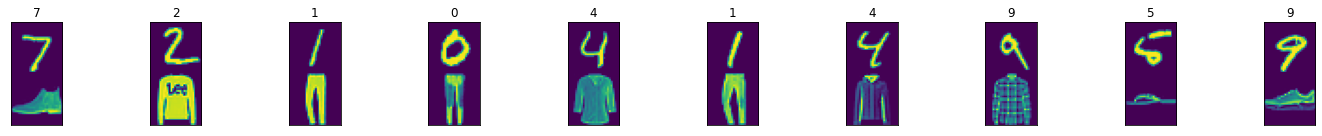

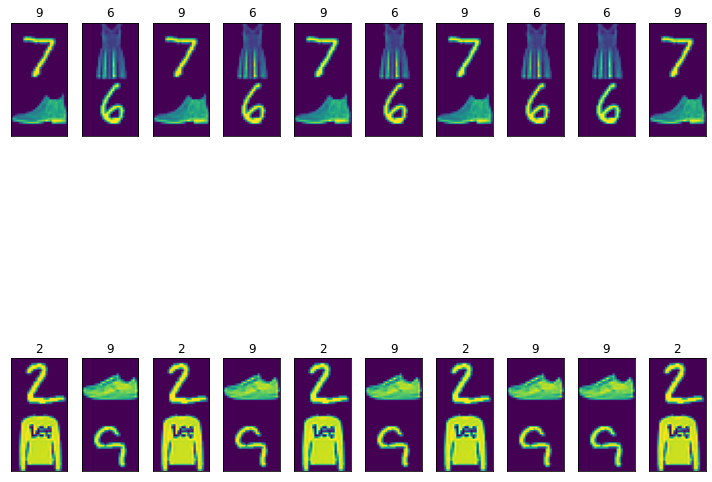

In [12]:
data, target = next(iter(multi_loaders[1]))
d = 0
plot([data[i, :, ...].reshape(1, 56, 28) for i in range(10)], [target[i, d] for i in range(10)], figsize=(20, 2))
data_t, target_t = varying_temporal_data(data, target, 5, False, True)
plot([[dt[:, i, ...].reshape(1, 56, 28) for dt in data_t] for i in range(2)], [[t[i, 1] for t in target_t] for i in range(2)], figsize=(10, 12))

## Training

In [54]:
n_epochs = 10
#task = 'none'
task = '100_class'
#task = 'parity_digits_10'
#task = 'rotation_conflict_2'
decision_params = ('last', 'max')

double_training = True

if double_training : 
    #loaders = double_mnist_loaders
    loaders = multi_loaders
    model, optimizers = community, optimizers
else:
    loaders = mnist_loaders
    model, optimizers = community.agents[0], [optim_1, None]

train_out = train_community(model, device, *loaders, optimizers, n_epochs=n_epochs,
                            global_rewire=False, schedulers=schedulers, task=task, early_stop=True, reg_factor=0.,
                            deepR_params_dict=deepR_params_dict, decision_params=decision_params, train_connections=True,
                            check_gradients=False, use_tqdm=0, notebook=True, trials=(True, True))

(train_losses, train_accs), (test_losses, test_accs), deciding_agents, best_state = train_out

Train Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
for p in community.parameters() : 
    p.requires_grad = False

In [ ]:
n_epochs = 10
#task = 'none'
task = '100_class'
#task = 'parity_digits_10'
#task = 'rotation_conflict_2'
decision_params = ('last', 'max')

double_training = True

if double_training : 
    loaders = double_mnist_loaders
    model, optimizers = community, optimizers
else:
    loaders = mnist_loaders
    model, optimizers = community.agents[0], [optim_1, None]

train_out = train_community(model, device, *loaders, optimizers, n_epochs=n_epochs,
                            global_rewire=False, schedulers=schedulers, task=task, early_stop=True, reg_factor=0.,
                            deepR_params_dict=deepR_params_dict, decision_params=decision_params, train_connections=True,
                            check_gradients=False, use_tqdm=0, notebook=True, trials=(True, True))

(train_losses, train_accs), (test_losses, test_accs), deciding_agents, best_state = train_out

In [55]:
def readout_retrain(community, loaders, n_classes=10, lrs=[1e-3, 1e-3], n_epochs=5, n_tests=3,
                    use_tqdm=False, train_all_param=False, device=torch.device('cuda')) : 
    """
    Retrains the bottleneck-readout connections of each sub-network for each sub-task and stores performance.
    Args : 
        community : trained model on global task
        n_classes : number of classes of the new readout layer
        loader : training and testing data-loaders
        n_tests : number of init and train to conduct
        n_epochs : number of epochs of training
        lrs : learning rate of training : [subnets, connections]
        train_all_params : train all sub-networks parameters as well as interconnections. If False, train only one bottleneck-readout at a time
    """
    
    double_train_loader, double_test_loader = loaders
    
    pbar = range(n_tests)
    if use_tqdm : 
        pbar = tqdm_n(pbar, position=2, desc='Metric Trials : ', leave=None)
    #single_losses_total, single_accs_total = [], []
    single_losses_total, single_accs_total = [], []
    for test in pbar : 
        single_losses_dig, single_accs_dig = [[] for _ in range(2)], [[] for _ in range(2)]
        
        for target_digit in range(2) :
            single_losses_ag, single_accs_ag = [[] for _ in range(2)], [[] for _ in range(2)]
            for n in range(2) : 
                f_community = copy.deepcopy(community)
                for f_agent in f_community.agents : 
                    if f_agent.use_bottleneck : 
                        f_agent.readout = nn.Linear(f_agent.bottleneck.out_features, n_classes)
                    else : 
                        f_agent.readout = nn.Linear(f_agent.dims[-2], n_classes)
                    f_agent.to(device)

                for name, p in f_community.named_parameters() : 
                    if 'readout' in name and str(n) in name:
                        p.requires_grad = True
                    else : 
                        p.requires_grad = train_all_param
            
                params = lr_ag, gamma = lrs[0], 0.9
                params_dict = {'lr' : lr_ag, 'gamma' : gamma}

                deepR_params = l1, gdnoise, lr_con, gamma, cooling = 1e-5, 1e-3, lrs[1], 0.95, 0.95
                deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr_con, 'gamma' : gamma, 'cooling' : cooling}
                
                decision_params = ('last', str(n))    
                optimizers, schedulers = init_optimizers(f_community, params_dict, deepR_params_dict)
                optimizer_agents = optimizers[0]
                
                train_out = train_community(f_community, device, double_train_loader, double_test_loader, optimizers, 
                            n_epochs=n_epochs, global_rewire=False, schedulers=schedulers, deepR_params_dict=deepR_params_dict,
                            decision_params=decision_params, task=str(target_digit), train_connections=False,
                            trials = (True, True), use_tqdm=True)

                (train_losses, train_accs), (test_losses, test_accs), *_ = train_out

                single_losses_ag[n].extend(test_losses)
                single_accs_ag[n].extend(test_accs)

            single_losses_dig[target_digit] = np.array(single_losses_ag)
            single_accs_dig[target_digit] = np.array(single_accs_ag)
        

        single_losses_total.append(np.array(single_losses_dig))
        single_accs_total.append(np.array(single_accs_dig))
            
    return {'losses' : np.array(single_losses_total), 'accs' : np.array(single_accs_total)}

In [56]:
results = readout_retrain(community, loaders, use_tqdm=True, n_epochs=1, n_tests=1)

Metric Trials :   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch: 0 [59904/60000 (100%)] Loss: 0.474 New Cons: 0 | Test set: Loss: 0.663, Accuracy: 7814/160000 (78%), Mean decider: 0.00:   0%|          | 0/1 [00:30<?, ?it/s]/home/gb21/.conda/envs/V2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Train Epoch: 0 [59904/60000 (100%)] Loss: 0.474 New Cons: 0 | Test set: Loss: 0.663, Accuracy: 7814/160000 (78%), Mean decider: 0.00: 100%|██████████| 1/1 [00:30<00:00, 30.17s/it]
Train Epoch: 0 [59904/60000 (100%)] Loss: 0.631 New Cons: 0 | Test set: Loss: 0.706, Ac

In [43]:
results

{'losses': array([[[[0.26023656],
          [0.22576411]],
 
         [[1.81461751],
          [0.29798457]]]]),
 'accs': array([[[[0.93176424],
          [0.93967563]],
 
         [[0.39675633],
          [0.92652294]]]])}

# Metrics

### Correlation 

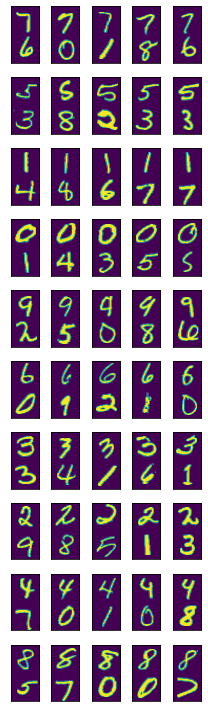

In [ ]:
datas, label = next(iter(double_mnist_loaders[0]))
datas = temporal_data(datas).to(device)
fixed_datas = fixed_information_data(datas, label, 'label', i=0)
fixed_datas = [[d.reshape(1, 56, 28) for d in data[0, :, :5, :].transpose(0, 1).cpu()] for data in fixed_datas]
plot(fixed_datas, figsize=(3, 1*len(fixed_datas)))

In [ ]:
#p_cons = np.geomspace(1e-4, 0.99, 25)
#p_cons = np.geomspace(1e-4, 0.99, 25)
#pearson_corrs = {}
l=0

#community_states = torch.load(community_state_path)
#states = community_states
#states = trained_states[0]

#states = {p : [t[-1] for t in train['parity']] for p, train in train_results.items()}

def get_correlations(states, use_tqdm=True) : 
    community = init_community(agents_params, p_connect, device, use_deepR, init_clone)

    pearson_corrs = {}
    p_cons = list(states.keys())
    pbar = p_cons[l:]
    if use_tqdm : 
        pbar = tqdm_n(pbar, position=0, desc='Model Sparsity', leave=None)

    for i, p_con in enumerate(pbar) : 
        pearson_corrs[p_con] = [[] for _ in range(2)]

        #for i, state in enumerate(tqdm(states[p_con][:], position=1, desc='Model Trials', leave=None)) : 
        for i, state in enumerate(states[p_con][:]) :
            community.load_state_dict(state)

            pearsons = get_pearson_metrics(community, double_mnist_loaders, n_tests=10, fixed_mode='label', use_tqdm=False, device=device)
            #pearsons2 = get_pearson_metrics(community, double_mnist_loaders, n_tests=20, fixed_mode='parity', use_tqdm=False, device=device)

            pearson_corrs[p_con][0].append(pearsons)
            #pearson_corrs[p_con][1].append(pearsons2)

        #pearson_corrs[p_con] = np.array(pearson_corrs[p_con])
        pearson_corrs[p_con][0] = np.array(pearson_corrs[p_con][0])
        #pearson_corrs[p_con][1] = np.array(pearson_corrs[p_con][1])

    pearson_correlations = copy.copy(pearson_corrs)
    
    return pearson_correlations

def plot_correlations(pearson_corrs, exp=None, **fig_kwargs) :
    p_cons = list(pearson_corrs.keys())
    diff_metric = lambda metric : (metric[n, n] - metric[n, n-1]) / ((metric[n, n] + metric[n, n-1]))
    fig, axes = plt.subplots(1, 2, **fig_kwargs)

    mean_metric = lambda metric : torch.tensor(metric).flatten(start_dim=3).mean(-1).data.numpy()

    linestyles = ['--', '-', ':']
    

    ax = axes[0]
    for n in range(2) : 
        for k in range(2) : 
            linestyle = linestyles[n]
            mean = np.array([corr[:, n, k, ...].mean() for corr in pearson_corrs.values()])
            std = np.array([corr[:, n, k, ...].std() for corr in pearson_corrs.values()])
            plot = ax.plot(p_cons, mean, label=f'Subnetwork {n}, Digit {k} Fixed', linestyle=linestyle)
            col = plot[-1].get_color()
            #ax.fill_between(p_cons, mean-std, mean+std, color=col, alpha=0.2)
            means = [mean_metric(corr) for corr in pearson_corrs.values()]
            for p, p_con in zip(means, p_cons[:l]) : 
                data_points = p[:, n, k].flatten()
                ax.plot([p_con]*int((len(data_points))), data_points, '.', color=col, alpha=0.4)
                
            ax.set_xscale('log')
            ax.legend()
    ax = axes[1]
    for n in range(2) : 
        ax.plot(p_cons, [diff_metric(corr.mean(-1).mean(-1).mean(0)) for corr in pearson_corrs.values()], label = f'Ag {n}')
        ax.set_xscale('log')    
        ax.legend()
                        
    fig.suptitle(exp)
    plt.show()

In [ ]:
#Load from WabndB artifacts :

entity = 'gbena'
project='Spec_vs_Sparsity'

task = 'rotation_conflict_4'
use_deepR = True
train_in_out = (True, True)

config = {'task' : task, 
}

states, artifacts, runs = get_wandb_artifact(config, name='state_dicts', process_config=True, ensure_latest=False)
corrs, _, _ = get_wandb_artifact(config, name='correlations', process_config=True, ensure_latest=False)


{'config.task': 'rotation_conflict_4'}


wandb: Downloading large artifact state_dicts:v46, 55.03MB. 1 files... Done. 0:0:0


{'config.task': 'rotation_conflict_4'}


wandb: Downloading large artifact correlations:v43, 68.48MB. 1 files... Done. 0:0:0


In [ ]:
state_path = 'trained_models/100_class_mnist/Community_State_Dicts_100'
states = torch.load(state_path)


In [ ]:
pearson_corrs = get_correlations(states)

Model Sparsity:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pearson_corrs = corrs['Pearson_Label']

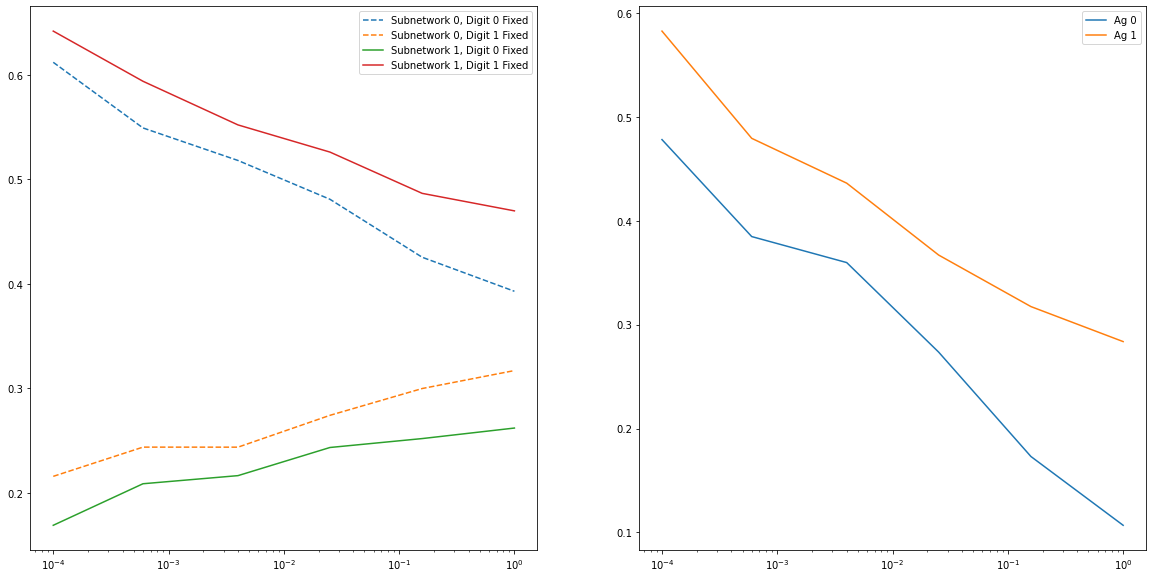

In [ ]:
plot_correlations(pearson_corrs, figsize=(20, 10))


### Correlation + Training

Try : swap batches every fwd, init w/ same weights

In [ ]:
loaders = double_mnist_loaders
decision_params = ['last', 'max']
use_deepR = True

def init_train(p_connect, reg, decision_params, init_clone, data_flip, early_stop) : 
    lrs = np.geomspace(deepR_params[2], deepR_params[2]/10, len(p_cons))
    community = init_community(agents_params, p_connect, device, use_deepR=use_deepR, init_clone=init_clone)
    deepR_params_dict['lr'] = lrs[(p_cons == p_connect)][0]
    #print(deepR_params_dict['lr'], community.nb_connections)
    optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)
    train_out = train_community(community, device, *loaders, optimizers, n_epochs=10, reg_factor=reg,
                                global_rewire=False, schedulers=schedulers, task=task, early_stop=early_stop, data_flip=data_flip,
                                deepR_params_dict=deepR_params_dict, decision_params=decision_params, use_tqdm=False)
    
    return community, train_out

p_cons = np.geomspace(1e-4, 0.99, 5)

n_tests = 1
train_results = {}
corr_results = {}

tasks = ['parity', 'parity_digits']
n_outs = [2, 10]
reg = 0.

pbar = tqdm(p_cons, position=0, leave=None)
for p_con in pbar : 
    i = 0
    corr_results[p_con] = {}
    train_results[p_con] = {} 
    #for n in tqdm(range(n_test), position=1, leave=None) : 
    for n_out, task in zip(n_outs, tasks) : 
        
        agents_params[5] = n_out
        trial = (task)
        corr_results[p_con][trial] = [[] for _ in range(2)]
        train_results[p_con][trial] = []
        for n in range(n_tests) : 
            #task = tasks[n%len(tasks)]
            #decision_params[1] = decider

            community, train_out_ = init_train(p_con, reg, decision_params, data_flip=False, init_clone=False, early_stop=True)
            train_results[p_con][trial].append(train_out_)
            community.load_state_dict(train_out_[-1])

            pearson_1 = get_pearson_metrics(community, loaders,fixed_mode='label', use_tqdm=False)
            pearson_2 = get_pearson_metrics(community, loaders,fixed_mode='parity', use_tqdm=False)

            corr_results[p_con][trial][0].append(pearson_1)
            corr_results[p_con][trial][1].append(pearson_2)
            i += 1

            pbar.set_description(f'{trial} : {i}/{len(tasks)*n_tests} Best Acc = {np.max(train_out_[1][1]):.2f}, Mean Decision = {train_out_[-2].mean():3f}')

        torch.save({'correlations' : corr_results, 'train_outs' : train_results}, f'testing/{task}')
#corr_results_2 = {p : np.array(v) for p, v in corr_results.items()}
#trained_states = {p : [v[-1] for v in value] for p, value in train_results.items()}


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
results = torch.load('testing/add_rand_equal')
corr_results, train_results = list(results.values())
tasks = ['parity_digits', 'parity_digits_inv']


In [ ]:
diff_metric = lambda metric, n : (metric[n, n] - metric[n, n-1]) / ((metric[n, n] + metric[n, n-1]))

def plot_trial_results(trial, task_mean=False) : 
    
    if not task_mean : 
        #(task, data_flip, init_clone, early_stop) = trial
        task = trial
        correlations = {p :[np.array(c) for c in v[trial]] for p, v in corr_results.items()}
        print([[c.shape for c in corr] for corr in correlations.values()])
        deciding_agents = {p : [d[-2] for d in v[trial]] for p, v in train_results.items()}
        #test_accs = {p : np.array([d[1][1] for d in v[trial]]) for p, v in train_results.items()}
        last_accs = {p : np.array([d[1][1][-1] for d in v[trial]]) for p, v in train_results.items()}
        max_accs = {p : np.array([max(d[1][1]) for d in v[trial]]) for p, v in train_results.items()}
        
        #trial_str = lambda :f'Task : {task}, Data Flip : {data_flip}, Init Clone : {init_clone}, Early Stop : {early_stop}' 
        trial_str = lambda :f'Task : {task} '

    else : 
        data_flip, init_clone, early_stop = trial
        get_trial = lambda task : (task, data_flip, init_clone, early_stop)
        trial_str = lambda :f'Mean of Tasks, Data Flip : {data_flip}, Init Clone : {init_clone}, Early Stop : {early_stop}'

        correlations = {p : np.concatenate([np.array([v[get_trial(task)][0]]) for task in tasks], 1) for p, v in corr_results.items()}
        deciding_agents = {p : np.concatenate([np.array([np.mean(d[-2]) for d in v[get_trial(task)]]) for task in tasks]) for p, v in train_results.items()}
        test_accs = {p : np.concatenate([np.array([np.mean(d[1][1]) for d in v[get_trial(task)]]) for task in tasks]) for p, v in train_results.items()}
        last_accs = {p : np.concatenate([np.array([d[1][1][-1] for d in v[get_trial(task)]]) for task in tasks]) for p, v in train_results.items()}
        max_accs = {p : np.concatenate([np.array([max(d[1][1]) for d in v[get_trial(task)]]) for task in tasks]) for p, v in train_results.items()}

    for lab, type in enumerate(['label', 'parity']) : 
        fig, axes = plt.subplots(1, 4, figsize=(20, 3))

        ax = axes[0]
        for n in range(2) : 
            for k in range(2) : 
                ax.plot(p_cons, [corr[lab].mean(-1).mean(-1).mean(0)[n ,k] for corr in correlations.values()], label = f'Ag {n} Task {k}', linestyle=linestyles[n])

        ax.set_xscale('log')
        ax.legend()
        ax.set_ylabel(f'Correlation {type}')

        ax = axes[1]
        for n in range(2) : 
            ax.plot(p_cons, [diff_metric(corr[lab].mean(-1).mean(-1).mean(0), n) for corr in correlations.values()], label = f'Ag {n}', linestyle=linestyles[n])

        ax.set_xscale('log')
        ax.legend()
        ax.set_ylabel(f'Correlation Diff {type}')

        ax = axes[2]
        ax.plot(p_cons, [np.mean([d.mean() for d in dec]) for dec in deciding_agents.values()], label='Mean decider')
        ax.legend()
        ax.set_xscale('log')

        ax = axes[3]
        ax.plot(p_cons, [t.mean() for t in max_accs.values()], 'b.', label='Max test acc')
        #ax.plot(p_cons, [t.mean(0).mean() for t in test_accs.values()], 'r.', label='Mean test acc')
        ax.legend()
        ax.set_xscale('log')


        fig.suptitle(trial_str())
        fig.tight_layout()

    plt.show()
            

[[(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)]]


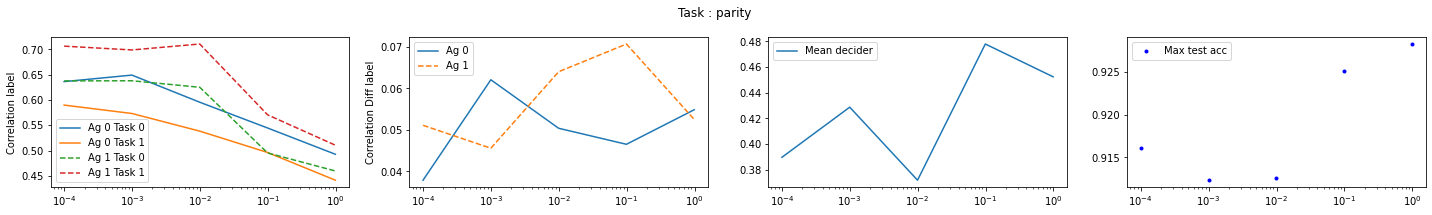

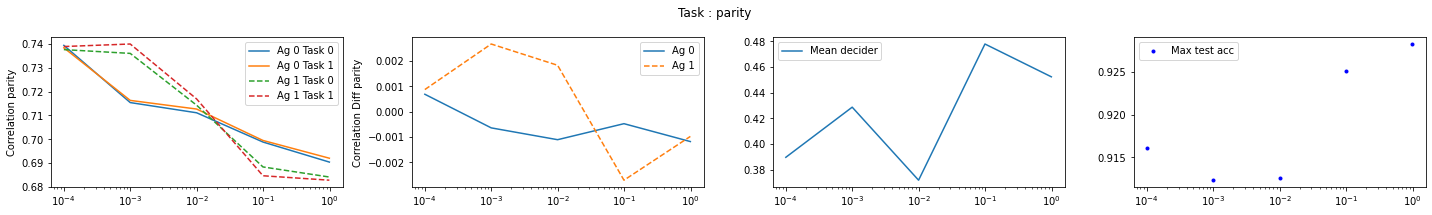

[[(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)], [(10, 2, 2, 32, 128), (10, 2, 2, 32, 64)]]


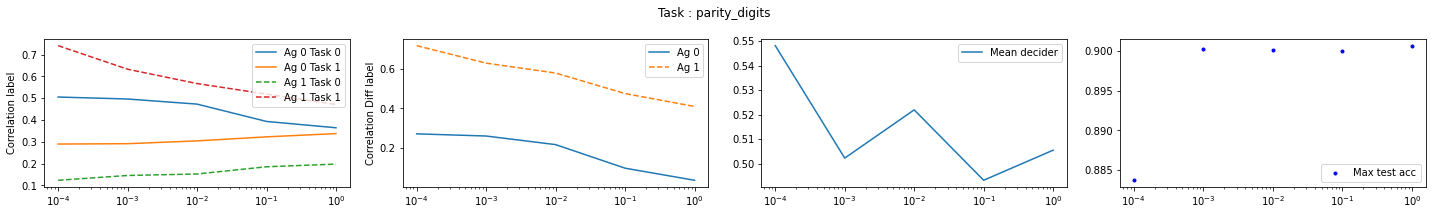

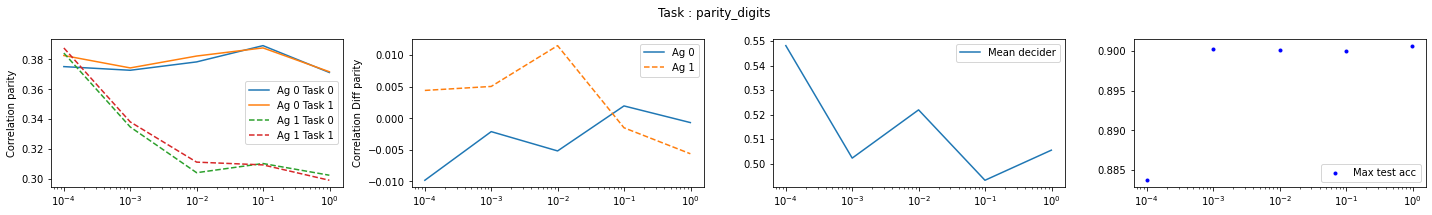

In [ ]:
#results = torch.load('testing/init_swap_comparison')
#results = torch.load('testing/add_rand_equal')


#corr_results, train_results = list(results.values())
linestyles = ['-', '--']
#p_cons = list(corr_results.keys())
tasks = ['parity', 'parity_digits']

for task in tasks : 
    results = torch.load(f'testing/{task}')
    corr_results, train_results = list(results.values())
    p_cons = list(corr_results.keys())

    #trial = (task, data_flip, init_clone, early_stop) 
    trial = (task)
    plot_trial_results(trial, False)
#trial = data_flip, init_clone, early_stop
#plot_trial_results(trial, True)
        

In [ ]:
corr_results[1e-4][task][1][1].shape

(2, 2, 32, 64)

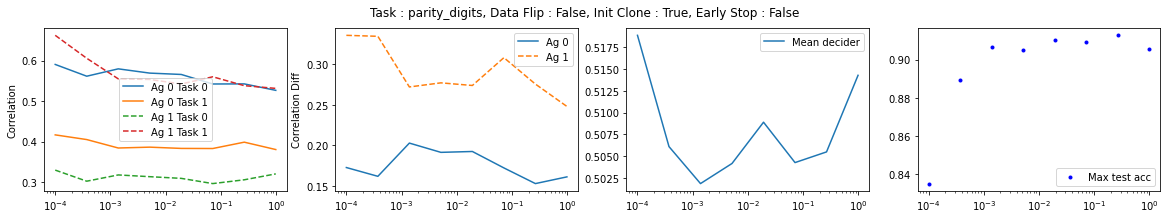

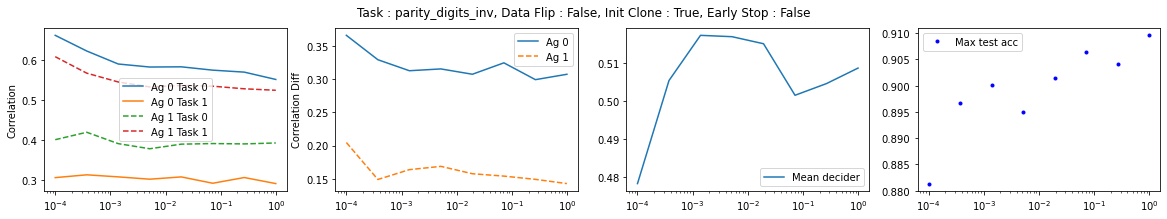

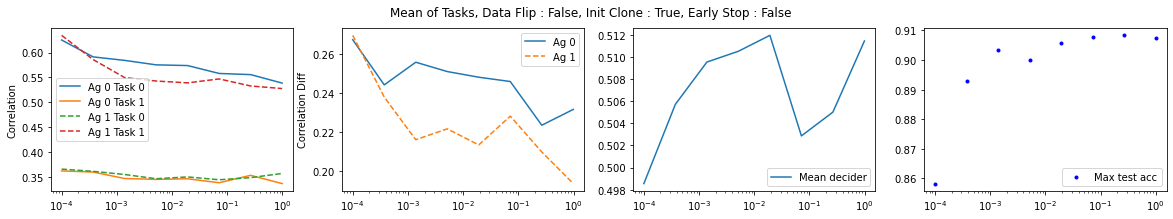

In [ ]:
#results = torch.load('testing/init_swap_comparison')
results = torch.load('testing/add_rand_equal')

corr_results, train_results = list(results.values())
linestyles = ['-', '--']
p_cons = list(corr_results.keys())

for data_flip in [False] : 
    for init_clone in [True] :
        for early_stop in [False] :
            for task in tasks : 
                trial = task, data_flip, init_clone, early_stop
                plot_trial_results(trial, False)
            
            trial = data_flip, init_clone, early_stop
            plot_trial_results(trial, True)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size, 'shuffle': True}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                'pin_memory': True
                }
    train_kwargs.update(cuda_kwargs)

root = os.path.expanduser("~/Code/Data/MNIST")
transformations= transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
    ])

class DoubleMNIST(Dataset) :
    """
    Double Digits MNIST dataset    
    """
    
    def __init__(self, root, train=True, transforms=None):
        super().__init__()

        self.transform=transforms
        dataset = datasets.MNIST(root, train=train, download=False,
                transform=self.transform)
        self.mnist_dataset = dataset
        self.secondary_index = torch.randperm(len(self.mnist_dataset))

    def __getitem__(self, index):
        index_1= index
        index_2 = self.secondary_index[index]

        digit_1, target_1 = self.mnist_dataset[index_1]
        digit_2, target_2 = self.mnist_dataset[index_2]

        digits = torch.cat([digit_1, digit_2], axis = 0)
        targets = [target_1, target_2]

        return digits, torch.tensor(targets)

    def __len__(self) : 
        return len(self.mnist_dataset)

double_dataset = DoubleMNIST(root, True, transformations)
loader = DataLoader(double_dataset, **train_kwargs)

model = nn.Sequential(nn.Linear(784, 100), nn.ReLU(), nn.Linear(100, 10)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = tqdm(range(1))
use_double = True

model.train()     
for epoch in pbar : 
    for batch_idx, batch in enumerate(loader):

        data, target = batch[0].to(device), batch[1].to(device)
        data, target = data[:, 0].flatten(start_dim=-2), target[:, 0]

        #print(target.is_contiguous())
        #target = target + 1 - 1

        optimizer.zero_grad()
        output = model(data)

        assert target.shape == output.shape[:-1], print(target.shape, output.shape)

        loss = F.cross_entropy(output, target, reduction='mean')
            
        pred = output.argmax(dim=-1)  # get the index of the max log-probability
        correct = pred.eq(target.view_as(pred)).sum().item()
        acc = correct/target.numel()
        
        loss.backward()

        if False : 
            check_grad(model)

        optimizer.step()

        desc = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Acc:{}'.format(
                epoch, batch_idx * loader.batch_size, len(loader.dataset),
                100. * batch_idx / len(loader), loss.item(), acc))


        pbar.set_description(desc)
